# LiteBIRD cosmic ray simulator
This variational autoencoder generates timelines of the power measured by the LiteBIRD bolometers during the impact of cosmic rays.
It is trained with data generated by a traditional cosmic ray simulator.

## Modules
We need the Keras API of Tensorflow 2.3.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

## Input data
To train the autoencoder, timestreams generated by a traditional cosmic ray simulator are used.

### Acquisition
The timestreams are stored in numpy arrays.
We read the files and store the data in a `(n_tods, 2, n_bolometers, n_timesteps)` array.

* The first dimension refers to the different samples.
* The second dimension refers to the time value (`[0]`) and the power value (`[1]`).
* The third dimension refers to the different bolometers.
* The fourth dimension refers to the different timesteps.

Since the timesteps are set beforehand (depending on the frequency of the sampling) and are the same in every timestream, they are not needed in the autoencoder.
The value of the power instead is what the autoencoder learns to predict.

In [2]:
# The number of input samples
n_tods = 956
# The number of bolometers we want to use
# The max is 12 since data files contain 12 of them
n_bolometers = 12

# Load data into a (n_tods, 2, n_bolometers, n_timesteps) np array.
data = []
for i in range(1, n_tods+1):
    data.append(np.load(f"data/TOD_mc_{i:04}.npy")[:,:n_bolometers,:])
data = np.array(data)

# Store the timestep values in a (n_timesteps,) array.
# We won't need them to train the network.
timesteps = data[0, 0, 0]
n_timesteps = len(timesteps)

# Transform data to a (n_tods, n_timesteps, n_bolometers) np array.
# The axes get swapped because the convolutional network accepts input
#     in (timesteps, features) shape.
data = np.swapaxes(data, 2, 3)[:, 1]

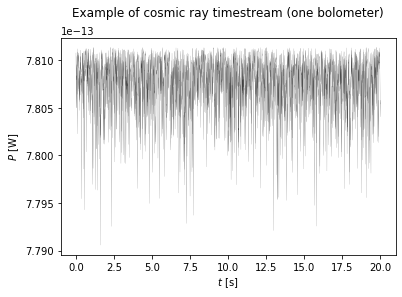

In [3]:
# Plot an example timestream.
plt.plot(timesteps, data[0, :, 0], color="k", linewidth=0.1);
plt.title("Example of cosmic ray timestream (one bolometer)\n");
plt.xlabel("$t~[\mathrm{s}]$");
plt.ylabel("$P~[\mathrm{W}]$");
#plt.savefig("images/input.svg");

### Normalization
The training process is easier if the data is centered around 0 and approximately spans the range \[-1, 1\].

In [6]:
# Save the max, min and median of the data
max_data = np.max(data)
min_data = np.min(data)
median = np.median(data)
    
def normalize_data(data):
    return (data - median) / (max_data - min_data)

def denormalize_data(data):
    return data * (max_data - min_data) + median

# Save the normalized data
normalized_data = normalize_data(data)

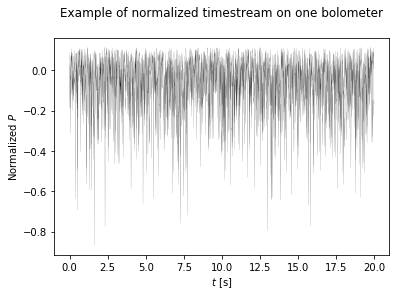

In [5]:
# Plot an example normalized timestream.
plt.plot(timesteps, normalized_data[0, :, 0], color="k", linewidth=0.1);
plt.title("Example of normalized timestream on one bolometer\n");
plt.xlabel("$t~[\mathrm{s}]$");
plt.ylabel("Normalized $P$");
#plt.savefig("images/normalized-input.svg");

## The autoencoder
First of all, define some constants that affect the neural network.

In [3]:
# The dimension of the latent space
latent_dim = 10
# The dimension of the convolutional kernel
kernel_size = 7
# The number of convolutional filters
n_filters = 32
# The number of dense units
n_units = 128
# The dropout rate
dropout_rate = 0.1

In [ ]:
# Instructions regarding eager execution (to be compatible with Tensorflow 2.0).
# TODO: make code work with Tensorflow 2.3 eager execution active.

# Uncomment the following line when training the model
#tf.compat.v1.disable_eager_execution()
# Uncomment the following line when loading a trained model
#tf.compat.v1.enable_eager_execution()

### The encoder
The encoder associates each data sample $x$ with an approximate posterior distribution $q(z|x)$ on the latent parameters $z$.
The posterior is a `latent_dim`-dimensional Gaussian, and the encoder outputs the mean and log_variance vectors.

In [7]:
# Input layer
encoder_input = layers.Input(shape=(n_timesteps, n_bolometers),
                             name="encoder_input")

# Convolutional layer
x = layers.Conv1D(n_filters, kernel_size, padding="same",
                  activation="relu", name="encoder_conv")(encoder_input)
x = layers.MaxPooling1D()(x)
x = layers.Dropout(dropout_rate)(x)

# Intermediate dense layer
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(n_units, activation="relu", name="encoder_dense")(x)
x = layers.Dropout(dropout_rate)(x)

# Output dense layers
z_mean = layers.Dense(latent_dim, name="mean")(x)
z_log_var = layers.Dense(latent_dim, name="log_variance")(x)

# Build the encoder
encoder = models.Model(encoder_input, [z_mean, z_log_var], name="encoder")

In [8]:
# Show the encoder structure
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 3126, 12)]   0                                            
__________________________________________________________________________________________________
encoder_conv (Conv1D)           (None, 3126, 32)     2720        encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1563, 32)     0           encoder_conv[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1563, 32)     0           max_pooling1d[0][0]              
____________________________________________________________________________________________

### The sampler
To feed a latent parameter $z$ into the decoder, we first need to sample it from the posterior $q(z|x)$.

In [9]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    
    # We can't sample from q(z|x) directly
    #     because we wouldn't be able to backpropagate
    
    # Sample a parameter epsilon distributed as N(epsilon; 0, 1)...
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev = 1.0)
    
    # ... and then transform it to z = g(epsilon),
    #     with g such that distributed as q(z|x)
    return z_mean + K.exp(z_log_var) * epsilon

# Lambda layer that applies the sampling function to the parameters of q(z|x)
z = layers.Lambda(sampling, name="sampling")([z_mean, z_log_var])

### The decoder
The decoder associates with each latent parameter $z$ a likelihood distribution $p(x|z)$ on the data $x$.
The distribution is a normal with variance $1$, and the decoder only outputs its mean value.

In [10]:
# Input layer
decoder_input = layers.Input(shape=K.int_shape(z)[1:], name="decoder_input")

# Intermediate first dense layer
x = layers.Dense(n_units, activation="relu")(decoder_input)
x = layers.Dropout(dropout_rate)(x)

# Intermediate second dense layer
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation="relu")(x)
x = layers.Dropout(dropout_rate)(x)

# Output convolutional layer
x = layers.Reshape(shape_before_flattening[1:])(x)
x_decoded = layers.Conv1DTranspose(n_bolometers, kernel_size, padding="same",
                                   strides=2, activation="tanh")(x)

# Build the decoder
decoder = models.Model(decoder_input, x_decoded, name="decoder")

In [11]:
# Show the decoder structure
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50016)             6452064   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50016)             0         
_________________________________________________________________
reshape (Reshape)            (None, 1563, 32)          0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 3126, 12)          2700

### Connecting the encoder and the decoder
Finally, we can connect the encoder and the decoder in the VAE.
We also build a custom loss layer, that is the sum of a reconstruction and a regularization term.
* The reconstruction term makes the output close to the input, so that the VAE can approximate the identity function.
* The regulatization term makes the posterior $q(z|x)$ close to the prior $N(z; 0, 1)$.

In [12]:
# The loss layer class
class LossLayer(layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        reconstruction_loss = metrics.mse(x, z_decoded)
        regularization_loss = -5e-4 * K.mean(
            1 + z_log_var-K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(reconstruction_loss + regularization_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
# Feed the sampled latent parameter into the decoder
z_decoded = decoder(z)

# Create a loss layer that takes the input data
#     and the generated output to compare them.
y = LossLayer(name="loss")([encoder_input, z_decoded])

# Build the VAE and compile it with an optimizer
vae = models.Model(encoder_input, y, name="vae")
vae.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3), loss=None)

## Training
We are now ready to train the network.
First of all, we define some constants.

In [13]:
# The number of the epochs to train the network for
epochs = 10
# The batch size of the data
batch_size = 25

To train the autoencoder, we don't use labeled data since the loss layer automatically the generated samples with the input.

In [14]:
# TODO: understand if validation or K-fold validation can be useful
print("Fit...", end=" ")
history = vae.fit(x=normalized_data, y=None, verbose=0,
                  epochs=epochs, batch_size=batch_size)
print("OK")

Fit... OK


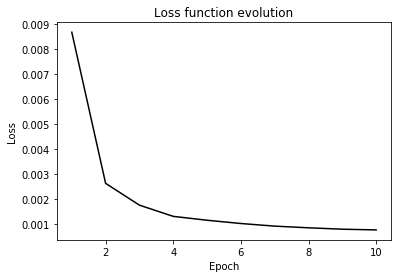

In [15]:
# Plot the value of the loss in the various epochs
plt.plot(list(range(1, len(history.history["loss"])+1)), history.history["loss"][0:],
         color="k", label="Training loss")
plt.title("Loss function evolution")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.savefig("images/loss.svg");

## Results

### The encoder
We print the posterior parameters coresponding to out input, to check if the posterior distribution is close to the prior $N(z; 0, 1)$, as should be thanks to the regularization loss.
Afterwards, we won't need the encoder anymore when generating data.

In [17]:
# Get the means and log variances of the posterior distributions corresponding to the input samples.
zs, log_vars = encoder.predict(data)
print("Min mean:     {:.1e}\tMean mean:     {:+.1e}\tMax mean:     {:+.1e}"
      .format(np.min(zs), np.mean(zs), np.max(zs)))
print("Min variance: {:+.1e}\tMean variance: {:+.1e}\tMax variance: {:+.1e}"
      .format(np.min(np.exp(log_vars)),
              np.mean(np.exp(log_vars)),
              np.max(np.exp(log_vars))))

Min mean:     -5.3e-02	Mean mean:     -2.6e-03	Max mean:     +6.2e-02
Min variance: +8.9e-01	Mean variance: +9.3e-01	Max variance: +9.6e-01


### The decoder
First of all, we plot a random output sample, feeding into the decoder a latent parameter generated with the prior.

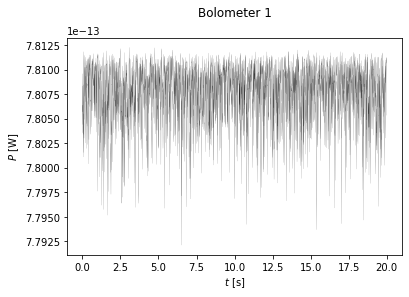

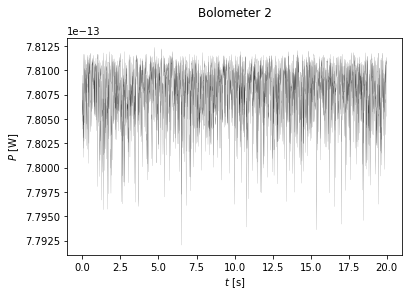

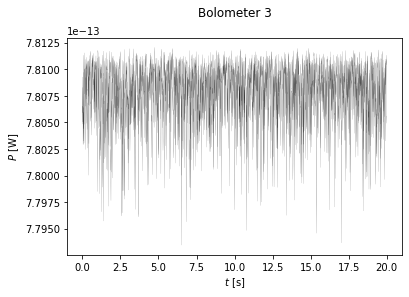

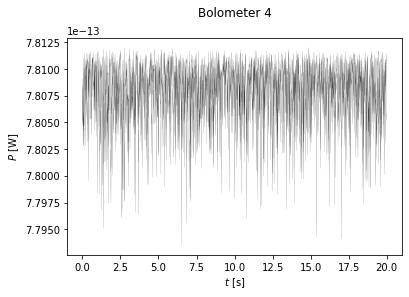

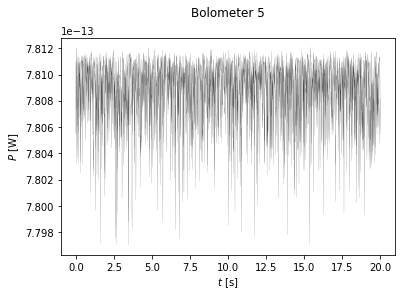

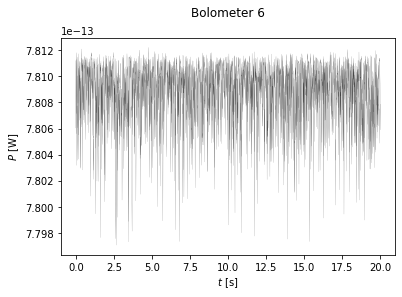

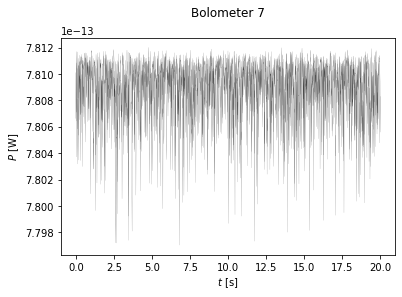

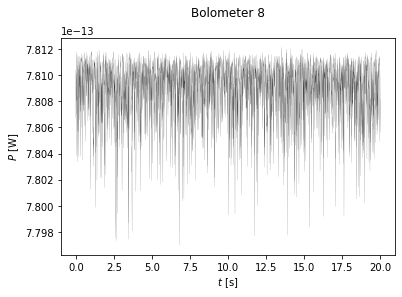

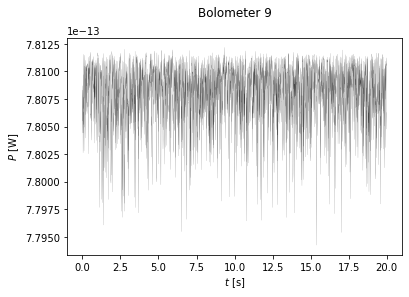

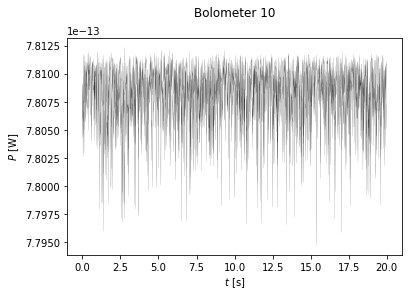

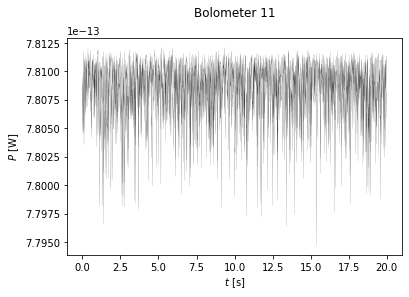

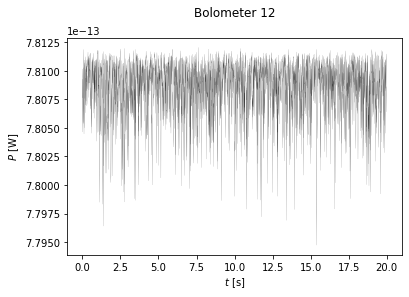

In [18]:
z_sample = np.random.normal(0., 1., (1, latent_dim))
x_decoded = decoder.predict(z_sample)
x_decoded = denormalize_data(x_decoded).reshape((n_timesteps, n_bolometers))
for i in range(n_bolometers):
    plt.plot(timesteps, x_decoded[:, i], color="k", linewidth=0.1);
    plt.title(f"Bolometer {i+1}\n")
    plt.xlabel("$t~[\mathrm{s}]$")
    plt.ylabel("$P~[\mathrm{W}]$")
    #plt.savefig(f"images/simulated-bolometer-{i+1}.svg")
    plt.show();

Afterwards, we generate `n_tods` samples on which we will perform some tests.

In [7]:
simulated_data = np.zeros((n_tods, n_timesteps, n_bolometers))

# Generate n_tods samples
for i in range(n_tods):
    z_sample = np.random.normal(0., 1, (1, latent_dim))
    x_decoded = decoder.predict(z_sample) 
    x_decoded = denormalize_data(x_decoded).reshape((n_timesteps, n_bolometers))
    simulated_data[i] = x_decoded
    
# Compute the mean of the input and generated data
mean_simulated_data = np.mean(simulated_data, axis=0)
mean_data = np.mean(data, axis=0)

A first test is comparing the distribution of power values of the input and generated samples.

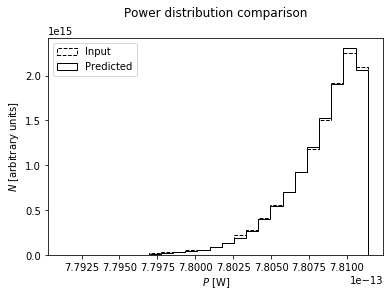

In [20]:
# Plot the power distribution of input samples
_, bins, _ = plt.hist(mean_data.reshape(n_timesteps * n_bolometers),
                      bins=25, density=True, histtype="step",
                      linestyle="--", color="k", label="Input");

# Plot the power distribution of generated samples
plt.hist(mean_simulated_data.reshape(n_timesteps * n_bolometers),
         bins=bins, density=True, histtype="step", linestyle="-",
         color="k", label="Predicted");

plt.legend(loc="upper left");
plt.title("Power distribution comparison\n")
plt.xlabel("$P~[\mathrm{W}]$")
plt.ylabel("$N~[$arbitrary units$]$");
#plt.savefig("images/power-distribution.svg");

Then, we see how various the generated samples are: if they are too similar, the network is overfitting.
We compare, between the input and generated data, the standard deviation of each timestep on the different tods.

Mean sigma of data:           1.7e-17	Max sigma of data:           8.9e-17
Mean sigma of simulated data: 1.4e-17	Max sigma of simulated data: 8.7e-17


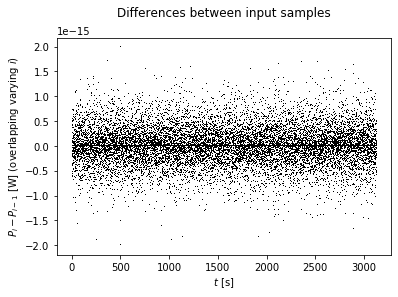

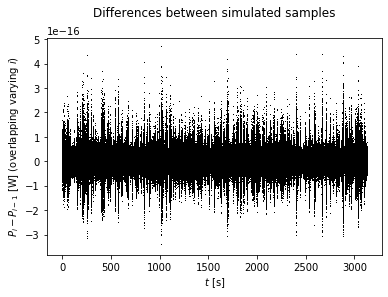

In [22]:
sigma_data = np.std(data, axis=0)
mean_sigma_data = np.mean(sigma_data)
max_sigma_data = np.max(sigma_data)

sigma_simulated_data = np.std(simulated_data, axis=0)
mean_sigma_simulated_data = np.mean(sigma_simulated_data)
max_sigma_simulated_data = np.max(sigma_simulated_data)

print("Mean sigma of data:           {:.1e}\tMax sigma of data:           {:.1e}"
      .format(mean_sigma_data, max_sigma_data))
print("Mean sigma of simulated data: {:.1e}\tMax sigma of simulated data: {:.1e}"
      .format(mean_sigma_simulated_data, max_sigma_simulated_data))

# Plot the difference between sample i and i-1, overlapping from 0 to n_tods
for i in range(n_tods):
    plt.plot(data[i,:,0]-data[i-1,:,0], ",", color="k");
plt.title("Differences between input samples\n")
plt.xlabel("$t~[\mathrm{s}]$")
plt.ylabel("$P_i - P_{i-1}~[\mathrm{W}]$ (overlapping varying $i$)")
#plt.savefig("images/diff-input.svg");
plt.show();

for i in range(n_tods):
    plt.plot(simulated_data[i,:,0]-simulated_data[i-1,:,0], ",", color="k");
plt.title("Differences between simulated samples\n")
plt.xlabel("$t~[\mathrm{s}]$")
plt.ylabel("$P_i - P_{i-1}~[\mathrm{W}]$ (overlapping varying $i$)")
#plt.savefig("images/diff-simulated.svg");
plt.show();

Finally, we compare the correlation matrices of the input and the output data: they should be as close as possible.

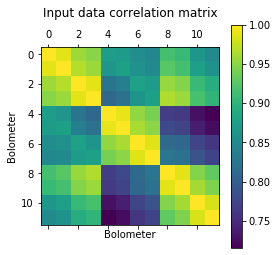

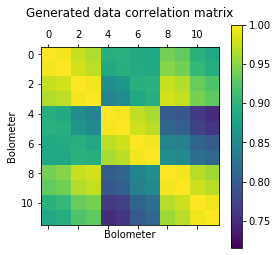

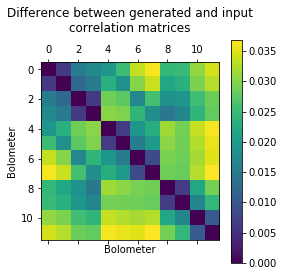

In [10]:
# Compute the correlation matrices between the bolometers
data_cor = np.corrcoef(mean_data, rowvar=False)
simulated_data_cor = np.corrcoef(mean_simulated_data, rowvar=False)

# Save max and min correlation to show the matrices on the same scale
min_cor = np.min((data_cor.min(), simulated_data_cor.min()))
max_cor = np.max((data_cor.max(), simulated_data_cor.max()))

# Input data correlation matrix
axes = plt.matshow(data_cor, vmin=min_cor, vmax=max_cor);
plt.colorbar(axes);
plt.title("Input data correlation matrix\n")
plt.xlabel("Bolometer")
plt.ylabel("Bolometer")
#plt.savefig("images/correlation-input.svg");
plt.show();

# Generated data correlation matrix
axes = plt.matshow(simulated_data_cor, vmin=min_cor, vmax=max_cor);
plt.title("Generated data correlation matrix\n")
plt.colorbar(axes);
plt.xlabel("Bolometer")
plt.ylabel("Bolometer")
#plt.savefig("images/correlation-output.svg");
plt.show();

# Difference between input and generated data correlation matrices
axes = plt.matshow(simulated_data_cor - data_cor);
plt.colorbar(axes);
plt.title("Difference between generated and input\ncorrelation matrices\n")
plt.xlabel("Bolometer")
plt.ylabel("Bolometer")
#plt.savefig("images/correlation-diff.svg");
plt.show();

## Loading and saving
If needed, we can save and load our trained network.
The lines are commented to prevent accidental data loss while executing the notebook.

In [24]:
#decoder.save("models/decoder.h5")
#encoder.save("models/encoder.h5")

In [ ]:
#decoder = models.load_model("models/decoder.h5")
#encoder = models.load_model("models/encoder.h5")